In [0]:
# some functions for image and plotting graph
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(26), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(26))
    ax2.set_yticklabels(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
##   download the dataset and upload it to your drive: https://drive.google.com/open?id=1lUt0lKeoBgnvM0E-G-KGV7wwHKuJHMhz
# necessary downloads
!wget https://github.com/dishank-b/Character_Segmentation/archive/master.zip
!unzip master.zip
!mv Character_Segmentation-master/* /content/
!rm -r segmented_img/img1/*
!wget https://i.imgur.com/sNrjsXD.jpg
!mv sNrjsXD.jpg /content/data/

In [0]:
# necessay imports/includes
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms

In [0]:
# network architecture (fully connected deep NN)
from torch import nn, optim
class Classify(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc0=nn.Linear(2352,784)
    self.fc1=nn.Linear(784,256)
    self.fc2=nn.Linear(256,256)
    self.fc3=nn.Linear(256,128)
    self.fc4=nn.Linear(128,64)
    self.fc5=nn.Linear(64,26)
    self.relu=nn.ReLU()
    self.ls=nn.LogSoftmax( dim=1)
  def forward(self,x):
        x = x.view(x.shape[0], -1) 
        x = self.relu(self.fc0(x))
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.ls(self.fc5(x))
        
        return x

In [0]:
def load_model(filepath):
    model = Classify()
    model.load_state_dict(torch.load(filepath))  
    return model

In [0]:
#### download .pth file and upload to drive: https://drive.google.com/open?id=1XQPYw5tiwc1oi1X_uv31ijrf4VFY816N

!cp "drive/My Drive/Colab Notebooks/Digify/digifymodel.pth" /content/

In [0]:
path = "./digifymodel.pth"
model=load_model(path)

<class 'numpy.ndarray'>


47775744

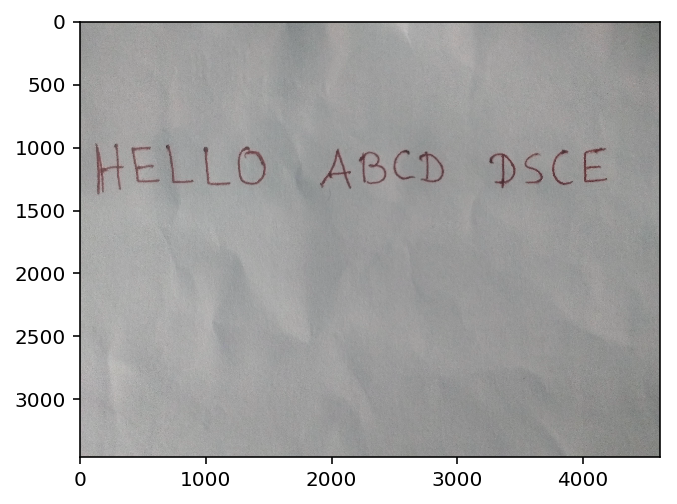

In [10]:
#### example image 
image_path = './data/sNrjsXD.jpg'
img = cv2.imread(image_path)

print(type(img))

plt.imshow(img)
img.size

In [0]:
# remove previously processed images

!rm -r segmented_img
!mkdir -p segmented_img/img1

In [12]:
### Process image to get characters

import cv2 
import numpy as np
import matplotlib.pyplot as plt
import os

np.set_printoptions()

#------------------Functions------------------#

def line_array(array):
	list_x_upper = []
	list_x_lower = []
	for y in range(5, len(array)-5):
		s_a, s_p = strtline(y, array)
		e_a, e_p = endline(y, array)
		if s_a>=7 and s_p>=5:
			list_x_upper.append(y)
			# bin_img[y][:] = 255
		if e_a>=5 and e_p>=7:
			list_x_lower.append(y)
			# bin_img[y][:] = 255
	return list_x_upper, list_x_lower

def strtline(y, array):
	count_ahead = 0
	count_prev = 0
	for i in array[y:y+10]:
		if i > 3:
			count_ahead+= 1  
	for i in array[y-10:y]:
		if i==0:
			count_prev += 1  
	return count_ahead, count_prev

def endline(y, array):
	count_ahead = 0
	count_prev = 0
	for i in array[y:y+10]:
		if i==0:
			count_ahead+= 1  
	for i in array[y-10:y]:
		if i >3:
			count_prev += 1  
	return count_ahead, count_prev

def endline_word(y, array, a):
	count_ahead = 0
	count_prev = 0
	for i in array[y:y+2*a]:
		if i < 2:
			count_ahead+= 1  
	for i in array[y-a:y]:
		if i > 2:
			count_prev += 1  
	return count_prev ,count_ahead

def end_line_array(array, a):
	list_endlines = []
	for y in range(len(array)):
		e_p, e_a = endline_word(y, array, a)
		# print(e_p, e_a)
		if e_a >= int(1.5*a) and e_p >= int(0.7*a):
			list_endlines.append(y)
	return list_endlines

def refine_endword(array):
	refine_list = []
	for y in range(len(array)-1):
		if array[y]+1 < array[y+1]:
			refine_list.append(array[y])
	refine_list.append(array[-1])
	return refine_list



def refine_array(array_upper, array_lower):
	upperlines = []
	lowerlines = []
	for y in range(len(array_upper)-1):
		if array_upper[y] + 5 < array_upper[y+1]:
			upperlines.append(array_upper[y]-10)
	for y in range(len(array_lower)-1):
		if array_lower[y] + 5 < array_lower[y+1]:
			lowerlines.append(array_lower[y]+10)

	upperlines.append(array_upper[-1]-10)
	lowerlines.append(array_lower[-1]+10)
	
	return upperlines, lowerlines

def letter_width(contours):
	letter_width_sum = 0
	count = 0
	for cnt in contours:
		if cv2.contourArea(cnt) > 20:
			x,y,w,h = cv2.boundingRect(cnt)
			letter_width_sum += w
			count += 1

	return letter_width_sum/count


def end_wrd_dtct(lines, i, bin_img, mean_lttr_width):
	count_y = np.zeros(shape = width)
	for x in range(width):
		for y in range(lines[i][0],lines[i][1]):
			if bin_img[y][x] == 255:
				count_y[x] += 1
	end_lines = end_line_array(count_y, int(mean_lttr_width))
	# print(end_lines)
	endlines = refine_endword(end_lines)
	for x in endlines:
		final_thr[lines[i][0]:lines[i][1], x] = 255
	return endlines

def letter_seg(lines_img, x_lines, i):
	copy_img = lines_img[i].copy()
	x_linescopy = x_lines[i].copy()
	
	letter_img = []
	letter_k = []
	
	chalu_img, contours, hierarchy = cv2.findContours(copy_img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)	
	for cnt in contours:
		if cv2.contourArea(cnt) > 50:
			x,y,w,h = cv2.boundingRect(cnt)
			# letter_img.append(lines_img[i][y:y+h, x:x+w])
			letter_k.append((x,y,w,h))

	letter = sorted(letter_k, key=lambda student: student[0])
	# print(letter)
	kernel = np.ones((2,2),np.uint8)
	word = 1
	letter_index = 0
	for e in range(len(letter)):
		if(letter[e][0]<x_linescopy[0]):
			letter_index += 1
			letter_img_tmp = lines_img[i][letter[e][1]-5:letter[e][1]+letter[e][3]+5,letter[e][0]-5:letter[e][0]+letter[e][2]+5]
			letter_img = cv2.resize(letter_img_tmp, dsize =(28, 28), interpolation = cv2.INTER_AREA)
			letter_img = cv2.bitwise_not(letter_img)
			letter_img = cv2.dilate(255-letter_img,kernel,iterations = 1) #dilation
			cv2.imwrite('./segmented_img/img1/'+str(i+1)+'_'+str(word)+'_'+str(letter_index)+'.jpg', letter_img)
		else:
			x_linescopy.pop(0)
			word += 1
			letter_index = 1
			letter_img_tmp = lines_img[i][letter[e][1]-5:letter[e][1]+letter[e][3]+5,letter[e][0]-5:letter[e][0]+letter[e][2]+5]
			letter_img = cv2.resize(letter_img_tmp, dsize =(28, 28), interpolation = cv2.INTER_AREA)
			letter_img = cv2.bitwise_not(letter_img)
			letter_img = cv2.dilate(255-letter_img,kernel,iterations = 1) #dilation
			cv2.imwrite('./segmented_img/img1/'+str(i+1)+'_'+str(word)+'_'+str(letter_index)+'.jpg', letter_img)
			# print(letter[e][0],x_linescopy[0], word)
						
#------------------/Functions-----------------#


#-------------Thresholding Image--------------#


print("\n........Program Initiated.......\n")
src_img= cv2.imread(image_path, 1)
copy = src_img.copy()
height = src_img.shape[0]
width = src_img.shape[1]


print("\n Resizing Image........")
src_img = cv2.resize(copy, dsize =(1320, int(1320*height/width)), interpolation = cv2.INTER_AREA)

height = src_img.shape[0]
width = src_img.shape[1]

print("#---------Image Info:--------#")
print("\tHeight =",height,"\n\tWidth =",width)
print("#----------------------------#")

grey_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)

print("Applying Adaptive Threshold with kernel :- 21 X 21")
bin_img = cv2.adaptiveThreshold(grey_img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,21,20)
bin_img1 = bin_img.copy()
bin_img2 = bin_img.copy()

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
kernel1 = np.array([[1,0,1],[0,1,0],[1,0,1]], dtype = np.uint8)
# final_thr = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel)
# final_thr = cv2.dilate(bin_img,kernel1,iterations = 1)
print("Noise Removal From Image.........")
final_thr = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel)
contr_retrival = final_thr.copy()

#-------------/Thresholding Image-------------#


#-------------Line Detection------------------#
print("Beginning Character Semenation..............")
count_x = np.zeros(shape= (height))
for y in range(height):
	for x in range(width):
		if bin_img[y][x] == 255 :
			count_x[y] = count_x[y]+1
	# print(count_x[y])

# t = np.arange(0,height, 1)
# plt.plot(t, count_x[t])
# plt.axis([0, height, 0, 350])

upper_lines, lower_lines = line_array(count_x)

upperlines, lowerlines = refine_array(upper_lines, lower_lines)

# print(upperlines, lowerlines)
if len(upperlines)==len(lowerlines):
	lines = []
	for y in upperlines:
		final_thr[y][:] = 255	
	for y in lowerlines:
		final_thr[y][:] = 255
	for y in range(len(upperlines)):
		lines.append((upperlines[y], lowerlines[y]))
	
else:
	print("Too much noise in image, unable to process.\nPlease try with another image. Ctrl-C to exit:- ")
	showimages()
	k = cv2.waitKey(0)
	while 1:
		k = cv2.waitKey(0)
		if k & 0xFF == ord('q'):
			cv2.destroyAllWindows()
			exit()

lines = np.array(lines)

no_of_lines = len(lines)

print("\nGiven Text has   # ",no_of_lines, " #   no. of lines")

lines_img = []

for i in range(no_of_lines):
	lines_img.append(bin_img2[lines[i][0]:lines[i][1], :])

#-------------/Line Detection-----------------#
 

#-------------Letter Width Calculation--------#

contr_img, contours, hierarchy = cv2.findContours(contr_retrival,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
final_contr = np.zeros((final_thr.shape[0],final_thr.shape[1],3), dtype = np.uint8)
cv2.drawContours(src_img, contours, -1, (0,255,0), 1)

mean_lttr_width = letter_width(contours)
print("\nAverage Width of Each Letter:- ", mean_lttr_width)

#-------------/Letter Width Calculation-------#

#--------------Word Detection-----------------#
x_lines = []

for i in range(len(lines_img)):
	x_lines.append(end_wrd_dtct(lines, i, bin_img, mean_lttr_width))

for i in range(len(x_lines)):
	x_lines[i].append(width)

print(x_lines)
#-------------/Word Detection-----------------#

#-------------Letter Segmentation-------------#

for i in range(len(lines)):
	letter_seg(lines_img, x_lines, i)	


#------------\Letter Segmentation-------------#


#-------------Character segmenting------------#

chr_img = bin_img1.copy()

contr_img, contours, hierarchy = cv2.findContours(chr_img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
# print(len(contours))
# final_contr = np.zeros((final_thr.shape[0],final_thr.shape[1],3), dtype = np.uint8)
# cv2.drawContours(src_img, contours, -1, (0,255,0), 1)

for cnt in contours:
	if cv2.contourArea(cnt) > 20:
		x,y,w,h = cv2.boundingRect(cnt)
		cv2.rectangle(src_img,(x,y),(x+w,y+h),(0,255,0),2)
		

#-------------/Character segmenting-----------# 


........Program Initiated.......


 Resizing Image........
#---------Image Info:--------#
	Height = 990 
	Width = 1320
#----------------------------#
Applying Adaptive Threshold with kernel :- 21 X 21
Noise Removal From Image.........
Beginning Character Semenation..............

Given Text has   #  1  #   no. of lines

Average Width of Each Letter:-  58.07692307692308
[[441, 845, 1217, 1320]]


<class 'numpy.ndarray'>


2352

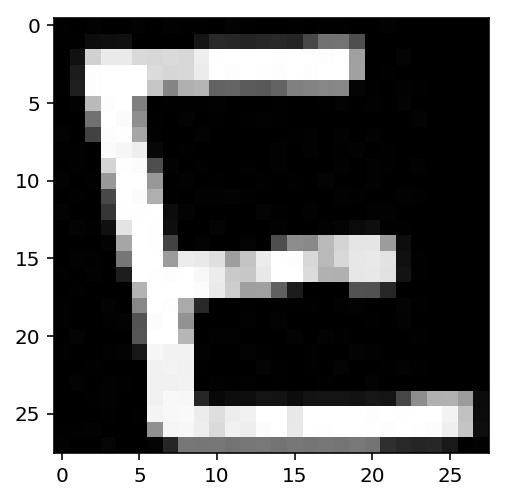

In [13]:
# check processed character

# Load image
img = cv2.imread('segmented_img/img1/1_1_3.jpg')

print(type(img))

plt.imshow(img)
img.size

In [0]:
# number of characters in whole image

num=!ls -l segmented_img/img1/ | wc -l

Character: E


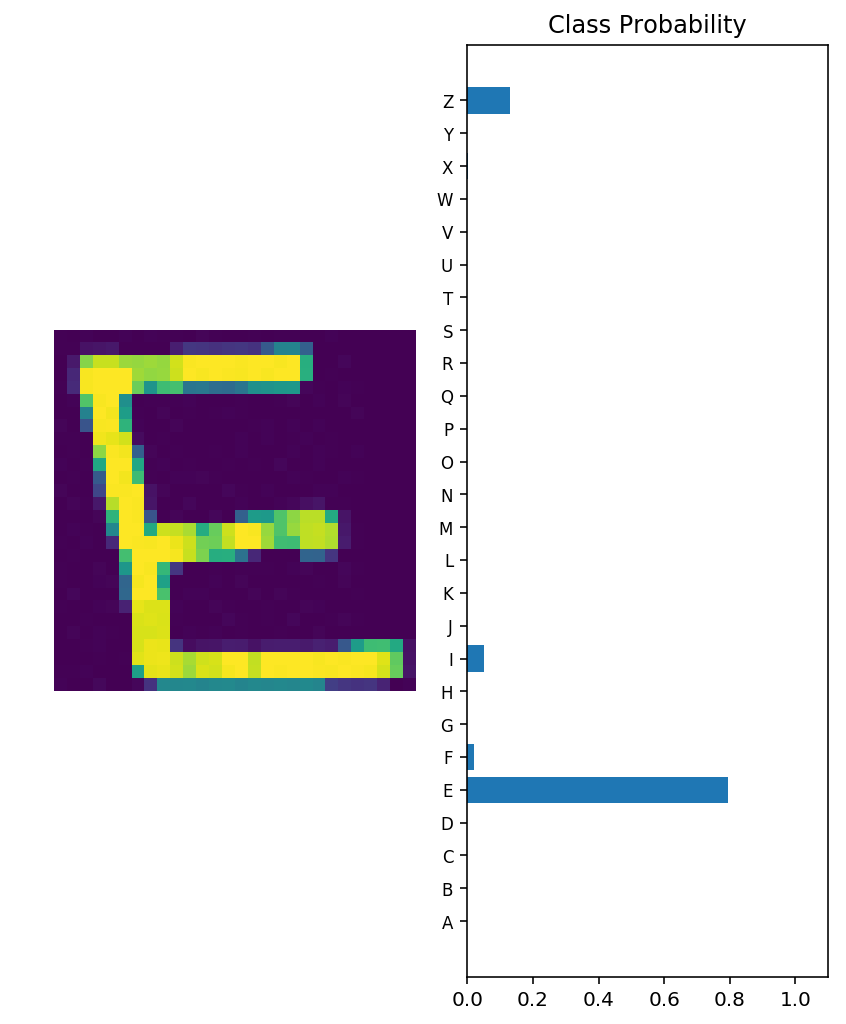

In [24]:
# check probability of one of the characters

%matplotlib inline
import helper

transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
data = datasets.ImageFolder('segmented_img/', transform=transform)
loader = torch.utils.data.DataLoader(data, batch_size=int(num[0]))
images,labels = next(iter(loader))
img = images[2].view(1, 2352)
with torch.no_grad():
    logps = model(img)
ps = torch.exp(logps)
view_classify(img.view(3, 28, 28), ps)

m = ps.argmax(1)
print("Character: "+str(chr(m.item()+65)))

In [0]:
img_names=!ls segmented_img/img1/ | sort
nwords=[]
nlines=[]
for name in img_names:
  nwords.append(name[2])
  nlines.append(name[0])
nwords.append(-1)
nlines.append(-1)

In [23]:
# recognizing characters in whole image
p=''
count=1
for i in images:
  img = i.view(1, 2352)
  with torch.no_grad():
      logps = model(img)
  ps = torch.exp(logps)
  m = ps.argmax(1)
  p+=str(chr(m.item()+65))
  if nwords[count] != nwords[count-1]:
    p+=" "
  if nlines[count] != nlines[count-1]:
    p+="\n"
  count+=1
print(p)

SHELLO ABCD DSCE 

